In [1]:
import datetime
import math
import holidays

import matplotlib.pyplot as plt
import seaborn as sns

import polars as pl
import numpy as np
import scipy

import pymc as pm
import bambi as bmb
import arviz as az

import warnings

import bimodal.config as config

sns.set(rc={'figure.figsize':(17,11)})

warnings.filterwarnings("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load data

In [2]:
daily_count_data = pl.read_parquet("../data/dataset_daily_counts.parquet")

In [3]:
# wind_df = pl.read_parquet("../data/weather_wind.parquet")
# rain_df = pl.read_parquet("../data/weather_rain.parquet")
# temperature_df = pl.read_parquet("../data/weather_temp.parquet")
# combined_weather = (
#     wind_df.join(
#         rain_df, on="record_time", how="left"
#     ).join(
#         temperature_df, on="record_time", how="left"
#     ).rename(
#         {
#             "speed_ms": "windspeed",
#             "dir_deg": "wind_direction",
#             "speed_std": "windspeed_std",
#             "amount": "rainfall",
#             "temp_avg_c": "temp_mean",
#             "temp_min_c": "temp_min",
#             "temp_max_c": "temp_max",
#         }
#     ).drop(
#         "dir_std", "period", "rel_humidity_perc"
#     )
# )

# holidays_df = pl.read_parquet("../data/wellington_holidays.parquet")

# data = (
#     pl.read_parquet(
#         "../data/counter_data.parquet"
#     ).join(
#         combined_weather, on="record_time", how="left"
#     ).with_columns(
#         pl.col("record_time").dt.date().alias("date")
#     ).join(
#         holidays_df, on="date", how="left"
#     ).drop(
#         "date"
#     ).with_columns(
#         # (pl.col("weekday") // 5).alias("is_weekend"),
#         (
#             pl.when(
#                 pl.col("holiday_name").is_not_null()
#             ).then(1).otherwise(0).alias("is_holiday")
#         ),
#         ((pl.col("record_time").dt.date() - config.INITIAL_DATE).dt.days()/365.25).alias("time_in_years"),
#         ((pl.col("windspeed") - pl.col("windspeed").mean())/pl.col("windspeed").std()).alias("windspeed_z"),
#         ((pl.col("temp_mean") - pl.col("temp_mean").mean())/pl.col("temp_mean").std()).alias("temperature_z"),
        
#     )
# )

In [4]:
START_YEAR = 2020
END_YEAR = 2023

SITE_NAMES = ["Adelaide Road"]

WEEKENDS = True
WEEKDAYS = True
HOLIDAYS = False

filtered_data = daily_count_data.filter(
    (pl.col("year").is_between(START_YEAR, END_YEAR))  &
    (pl.col("site_name").is_in(SITE_NAMES))
)
if WEEKENDS is False:
    filtered_data = filtered_data.filter(pl.col("weekday") < 5)
if WEEKDAYS is False:
    filtered_data = filtered_data.filter(pl.col("weekday") > 4)
if HOLIDAYS is False:
    filtered_data = filtered_data.filter(pl.col("is_holiday") != 1)
    


In [5]:
filtered_data = filtered_data.with_columns(
    ((pl.col("total_rainfall") + 1).log().alias("log_total_rainfall")),
    ((pl.col("median_wind_speed") - pl.col("median_wind_speed").mean())/pl.col("median_wind_speed").std()).alias("wind_speed_z"),
    ((pl.col("average_temperature") - pl.col("average_temperature").mean())/pl.col("average_temperature").std()).alias("temperature_z"),
).filter(
    pl.col("count_outgoing") > 0
)

In [6]:
# START_YEAR = 2020
# END_YEAR = 2023

# SITE_NAMES = ["Adelaide Road"]

# WEEKENDS = True
# WEEKDAYS = True
# HOLIDAYS = False

# filtered_data = data.filter(
#     (pl.col("year").is_between(START_YEAR, END_YEAR))  &
#     (pl.col("site_name").is_in(SITE_NAMES))
# )
# if WEEKENDS is False:
#     filtered_data = filtered_data.filter(pl.col("weekday") < 5)
# if WEEKDAYS is False:
#     filtered_data = filtered_data.filter(pl.col("weekday") > 4)
# if HOLIDAYS is False:
#     filtered_data = filtered_data.filter(pl.col("is_holiday") != 1)
    


In [7]:
# day_summary_data = (
#     filtered_data.group_by(
#         pl.col("year"), pl.col("month"), pl.col("day"), maintain_order=True
#     ).agg(
#         pl.col("weekday").first(),
#         pl.col("is_holiday").first(),
#         ((pl.col("record_time").dt.date().first() - config.INITIAL_DATE).dt.days() / 365.25).alias("time_in_years"),
#         pl.col("count_outgoing").sum(),
#         pl.col("count_incoming").sum(),
#         pl.col("rainfall").sum(),
#         pl.col("windspeed").median(),
#         pl.col("temp_mean").mean()
#     ).with_columns(
#         ((pl.col("windspeed") - pl.col("windspeed").mean())/pl.col("windspeed").std()).alias("windspeed_z"),
#         ((pl.col("temp_mean") - pl.col("temp_mean").mean())/pl.col("temp_mean").std()).alias("temperature_z"),
#     ).filter(
#         pl.col("count_outgoing") > 0
#     )
# )

In [8]:
month = filtered_data.select("month").to_numpy().flatten()
weekday = filtered_data.select("weekday").to_numpy().flatten()
holiday = filtered_data.select("is_holiday").to_numpy().flatten()
time_passed = filtered_data.select("time_in_years").to_numpy().flatten()
outgoing_count = filtered_data.select("count_outgoing").to_numpy().flatten()
rainfall = filtered_data.select("log_total_rainfall").to_numpy().flatten()
windspeed_z = filtered_data.select("wind_speed_z").to_numpy().flatten()
temperature_z = filtered_data.select("temperature_z").to_numpy().flatten()

## Helpers

In [9]:
def plot_daily_posterior_predictive(trace, step, offset=0, hdi=0.9):
    hdis = np.array(az.hdi(trace.posterior_predictive.counts, hdi_prob=hdi).to_array()).squeeze(0)
    
    n_x = (len(trace.observed_data.counts) - offset + step - 1) // step
    xs = np.arange(n_x)

    plt.title(f"Posterior predictive range (sampled every {step} days, hdi=0.9)")
    plt.xlabel("Day")
    plt.ylabel("Bikes counted")

    plt.scatter(xs, trace.observed_data.counts[offset::step], label="Observation")
    plt.scatter(xs, trace.posterior_predictive.counts[0,:,offset::step].mean(axis=0), alpha=0.3, color="darkorange", label="Posterior predictive mean")
    plt.vlines(xs, hdis[offset::step,0], hdis[offset::step,1], alpha=0.5, color="darkorange", label="HDI = 0.9")

    plt.xlim(-1, n_x + 1)
    plt.ylim(
        -1,
        (max(
            hdis[offset::step].max(), trace.observed_data.counts[offset::step].max()
           ) // 100 + 1
        ) * 100
    )

    plt.legend()
    plt.show();

In [10]:
def plot_daily_posterior_predictive_in_range(trace, step, start=0, end=None, hdi=0.9):
    if end == None:
        end = len(trace.posterior_predictive.counts)
    if end < start:
        raise RuntimeError("Range length must be positive")
    
    predicted = trace.posterior_predictive.counts[0,:,start:end:step]
    observed = trace.observed_data.counts[start:end:step]
    
    hdis = np.array(az.hdi(trace.posterior_predictive.counts[:,:,start:end:step], hdi_prob=hdi).to_array()).squeeze(0)
    
    xs = np.arange(len(observed))

    plt.title(f"Posterior predictive range (sampled every {step} days, hdi=0.9)")
    plt.xlabel("Day")
    plt.ylabel("Bikes counted")
    
    print(predicted.shape)

    plt.scatter(xs, observed, label="Observation")
    plt.scatter(xs, predicted.mean(axis=0), alpha=0.3, color="darkorange", label="Posterior predictive mean")
    plt.vlines(xs, hdis[:,0], hdis[:,1], alpha=0.5, color="darkorange", label="HDI = 0.9")

    plt.xlim(-1, len(observed) + 1)
    plt.ylim(
        -1,
        (max(
            hdis.max(), observed.max()
           ) // 100 + 1
        ) * 100
    )

    plt.legend()
    plt.show();

## First model: Complete pooling

In [11]:
with pm.Model() as model_cp:
    obs_count = pm.ConstantData("counts_obs", outgoing_count, dims="day")
    time = pm.ConstantData("time", time_passed, dims="day")
    
    γ = pm.Normal("γ", 0, 5)
    β = pm.Normal("β", 0, 0.1)
    μ = pm.Deterministic("μ", np.exp(γ + β*time))
    α = pm.Exponential("α", 1)
    counts = pm.NegativeBinomial("counts", mu=μ, alpha=α, observed=obs_count, dims="day")

## Second model: pool over weekdays

In [12]:
coords = {
    "weekday": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    "day_type": ["Weekday", "Weekend"],
}

with pm.Model(coords=coords) as model_pool_d:
    obs_count = pm.ConstantData("obs_count", outgoing_count, dims="day")
    obs_weekday = pm.ConstantData("obs_weekday", weekday, dims="day")
    time = pm.ConstantData("time", time_passed, dims="day")
    
    γ_wd_σ = pm.HalfNormal("γ_wd_σ", 0.25, dims="day_type")
    γ_wd_z = pm.Normal("γ_wd_z", 0, 1, dims="weekday")
    
    σ_indexes = np.where(np.arange(7) < 5, 0, 1)
    γ_wd = pm.Deterministic("γ_wd", γ_wd_z * γ_wd_σ[σ_indexes], dims="weekday")
    
    γ = pm.Normal("γ", 5.3, 0.15)
    β = pm.Normal("β", 0, 0.1)
    μ = pm.Deterministic("μ", np.exp(γ + γ_wd[obs_weekday] + β*time), dims="day")
    α = pm.Exponential("α", 1)
    
    counts = pm.NegativeBinomial("counts", mu=μ, alpha=α, observed=obs_count, dims="day")

## Third model: pool day and month

In [13]:
coords = {
    "weekday": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    "day_type": ["Weekday", "Weekend"],
    "month": ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
}

with pm.Model(coords=coords) as model_pool_dm:
    obs_count = pm.ConstantData("obs_count", outgoing_count, dims="day")
    obs_weekday = pm.ConstantData("obs_weekday", weekday, dims="day")
    obs_month = pm.ConstantData("obs_month", month, dims="day")
    time = pm.ConstantData("time", time_passed, dims="day")
    
    γ_wd_σ = pm.HalfNormal("γ_wd_σ", 0.25, dims="day_type")
    γ_wd_z = pm.Normal("γ_wd_z", 0, 1, dims="weekday")
    
    γ_m_σ = pm.HalfNormal("γ_m_σ", 0.25)
    γ_m_z = pm.Normal("γ_m_z", 0, 1, dims="month")
    
    σ_indexes = np.where(np.arange(7) < 5, 0, 1)
    γ_wd = pm.Deterministic("γ_wd", γ_wd_z * γ_wd_σ[σ_indexes], dims="weekday")
    γ_m = pm.Deterministic("γ_m", γ_m_z * γ_m_σ, dims="month")
    
    γ = pm.Normal("γ", 5.3, 0.15)
    β = pm.Normal("β", 0, 0.1)
    μ = pm.Deterministic("μ", np.exp(γ + γ_wd[obs_weekday] + γ_m[obs_month] + β*time), dims="day")
    α = pm.Exponential("α", 1)
    
    counts = pm.NegativeBinomial("counts", mu=μ, alpha=α, observed=obs_count, dims="day")

## Model 4: Pool day + month, weather features

In [14]:
coords = {
    "weekday": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    "day_type": ["Weekday", "Weekend"],
    "month": ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
    "weather_type": ["Rain", "Wind", "Temperature"],
}

with pm.Model(coords=coords) as model_pool_dm_weather:
    obs_count = pm.ConstantData("obs_count", outgoing_count, dims="day")
    obs_weekday = pm.ConstantData("obs_weekday", weekday, dims="day")
    obs_month = pm.ConstantData("obs_month", month, dims="day")
    obs_rain = pm.ConstantData("obs_rain", rainfall, dims="day")
    obs_wind = pm.ConstantData("obs_wind", windspeed_z, dims="day")
    obs_temp = pm.ConstantData("obs_temp", temperature_z, dims="day")
    time = pm.ConstantData("time", time_passed, dims="day")
    
    γ_wd_σ = pm.HalfNormal("γ_wd_σ", 0.25, dims="day_type")
    γ_wd_z = pm.Normal("γ_wd_z", 0, 1, dims="weekday")
    
    γ_m_σ = pm.HalfNormal("γ_m_σ", 0.25)
    γ_m_z = pm.Normal("γ_m_z", 0, 1, dims="month")
    
    β_weather = pm.Normal("β_weather", 0, 0.1, dims="weather_type")
    
    σ_indexes = np.where(np.arange(7) < 5, 0, 1)
    γ_wd = pm.Deterministic("γ_wd", γ_wd_z * γ_wd_σ[σ_indexes], dims="weekday")
    γ_m = pm.Deterministic("γ_m", γ_m_z * γ_m_σ, dims="month")
    
    γ = pm.Normal("γ", 5.3, 0.15)
    β = pm.Normal("β", 0, 0.1)
    μ = pm.Deterministic(
        "μ", 
        np.exp(
            γ + 
            γ_wd[obs_weekday] + 
            γ_m[obs_month] + 
            β_weather[0] * obs_rain +
            β_weather[1] * obs_wind +
            β_weather[2] * obs_temp +
            β*time
        ), 
        dims="day"
    )
    
    α = pm.Exponential("α", 1)
    
    counts = pm.NegativeBinomial("counts", mu=μ, alpha=α, observed=obs_count, dims="day")

## Analysis

In [15]:
models = {
    "No pooling": model_cp,
    "Pool days": model_pool_d,
    "Pool days + months": model_pool_dm,
    "Pool days + months, w weather": model_pool_dm_weather,
}

traces = {}
for name, model in models.items():
    with model:
        trace = pm.sample_prior_predictive(1000)
        trace.extend(pm.sample(10000, tune=10000, target_accept=0.98))
        trace.extend(pm.sample_posterior_predictive(trace))
        pm.compute_log_likelihood(trace)
    traces[name] = trace

Sampling: [counts, α, β, β_weather, γ, γ_m_z, γ_m_σ, γ_wd_z, γ_wd_σ]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ_wd_σ, γ_wd_z, γ_m_σ, γ_m_z, β_weather, γ, β, α]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 877 seconds.
Sampling: [counts]


In [16]:
az.compare(traces)

ValueError: not enough values to unpack (expected 2, got 0)

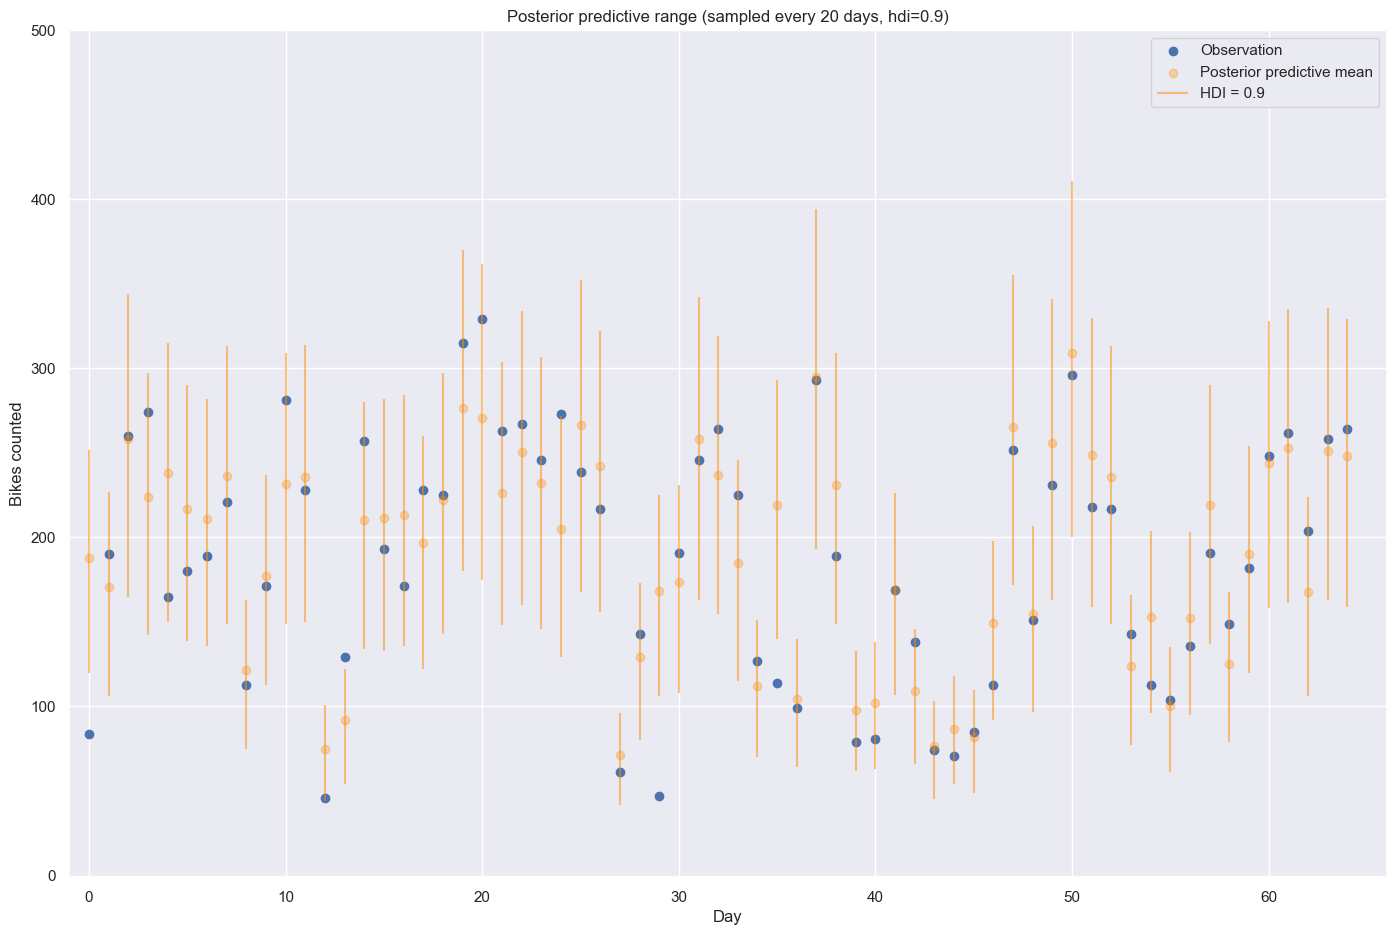

In [17]:
for trace in traces.values():
    plot_daily_posterior_predictive(trace, 20)

(10000, 122)


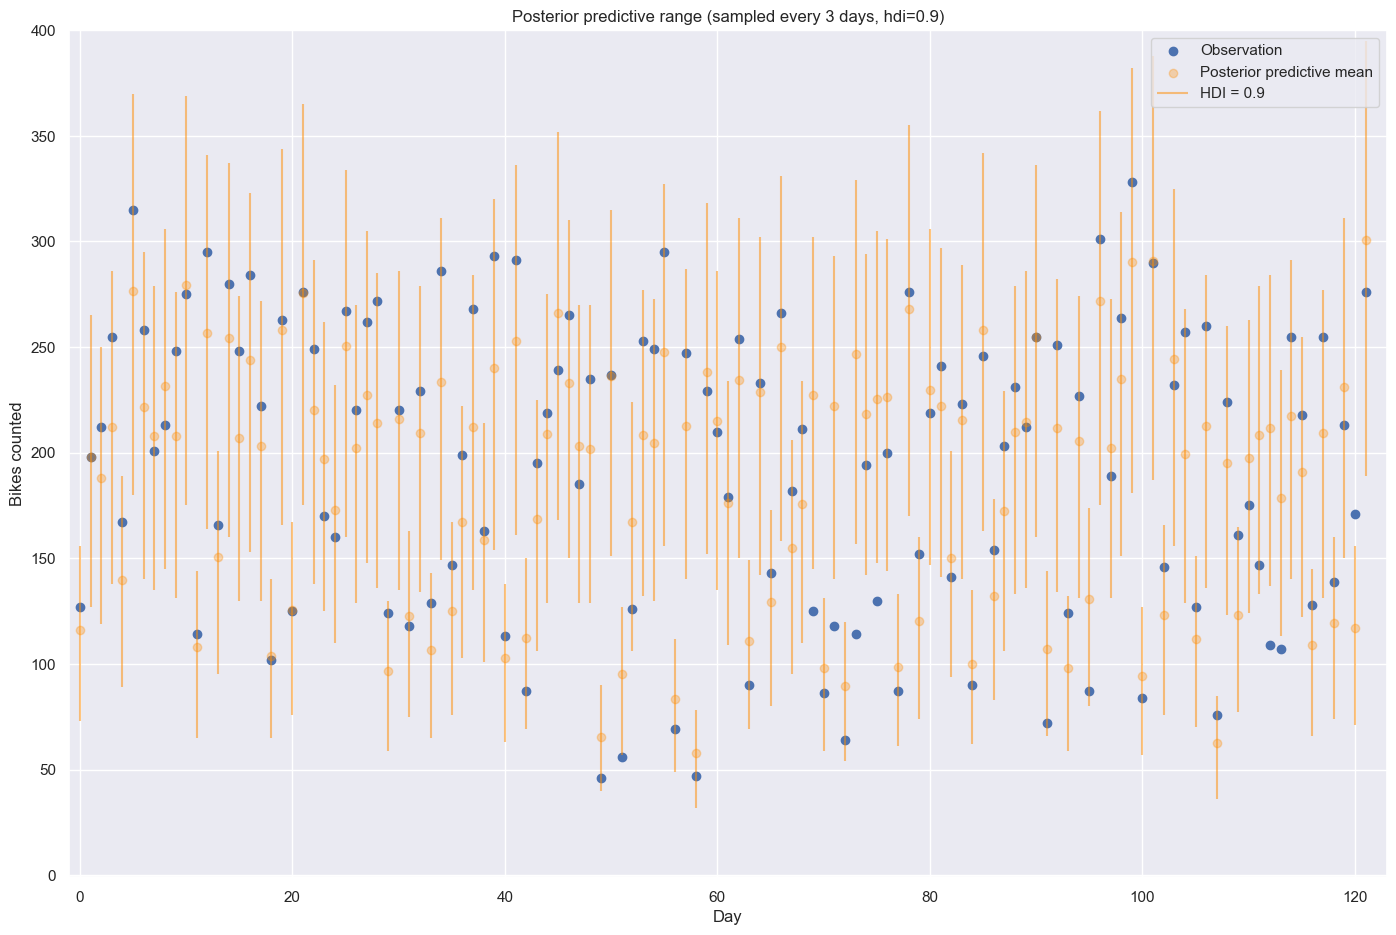

In [18]:
for trace in traces.values():
    plot_daily_posterior_predictive_in_range(trace, 3, 365, 730)

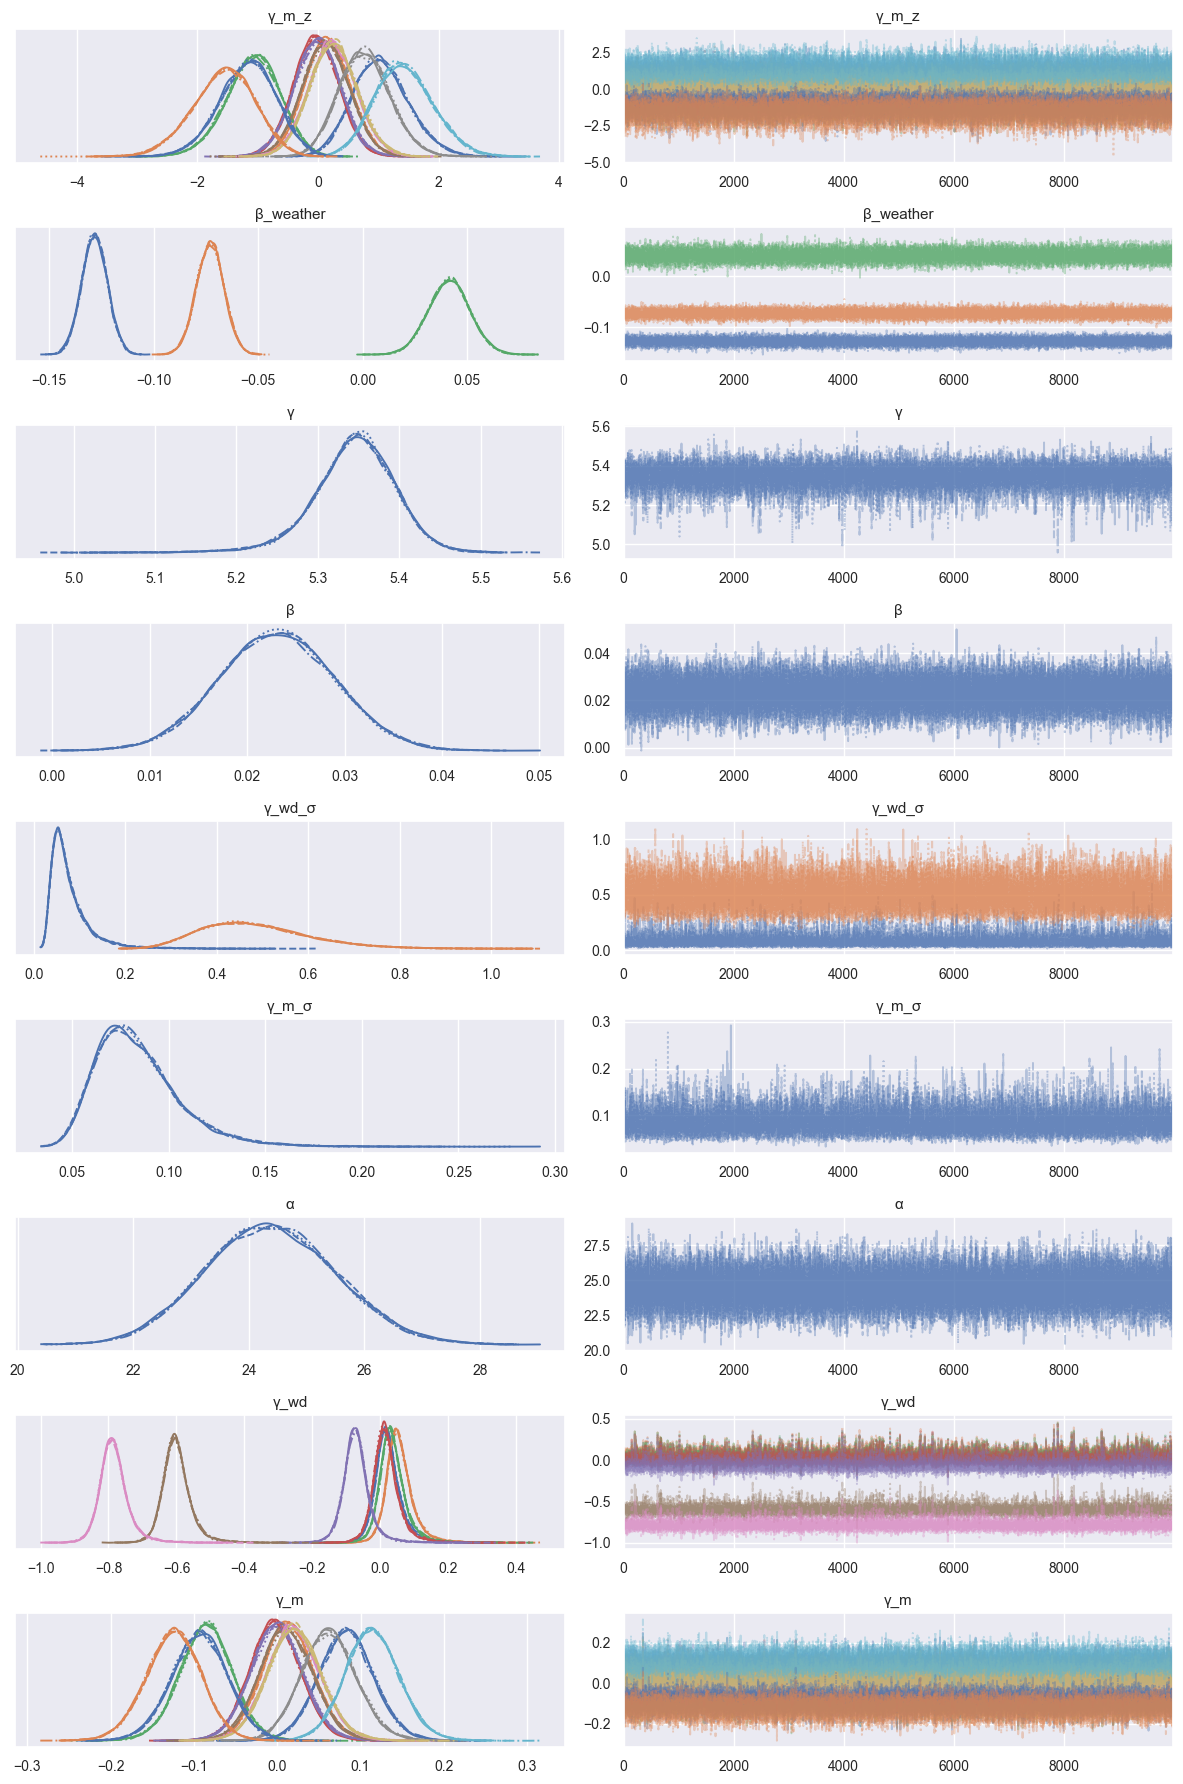

In [19]:
az.plot_trace(traces["Pool days + months, w weather"], var_names=["~μ", "~γ_wd_z", "γ_m_z"])
plt.tight_layout();

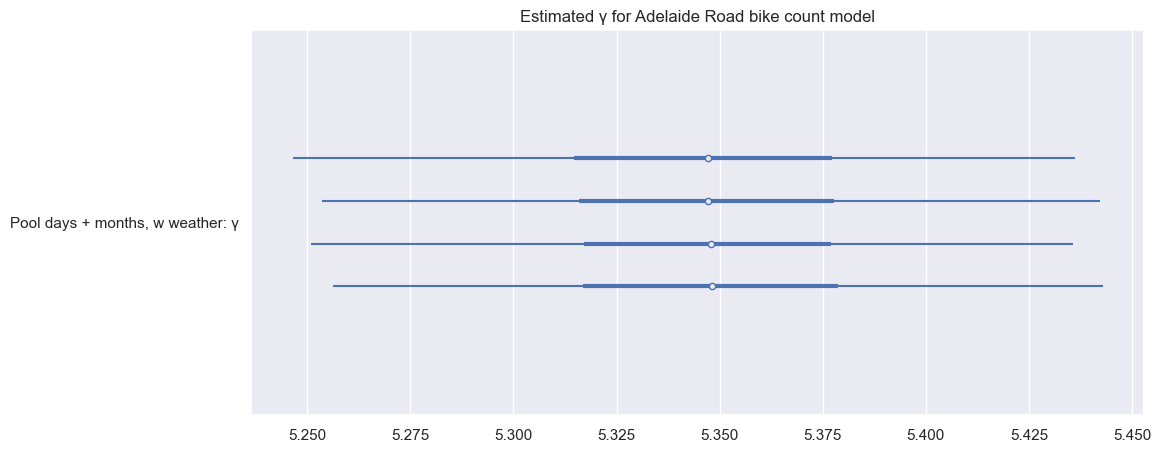

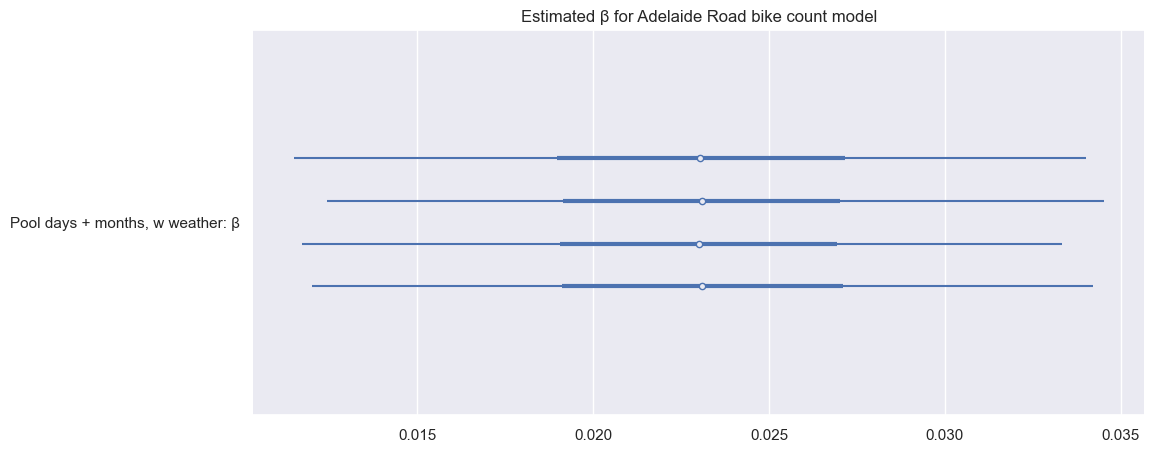

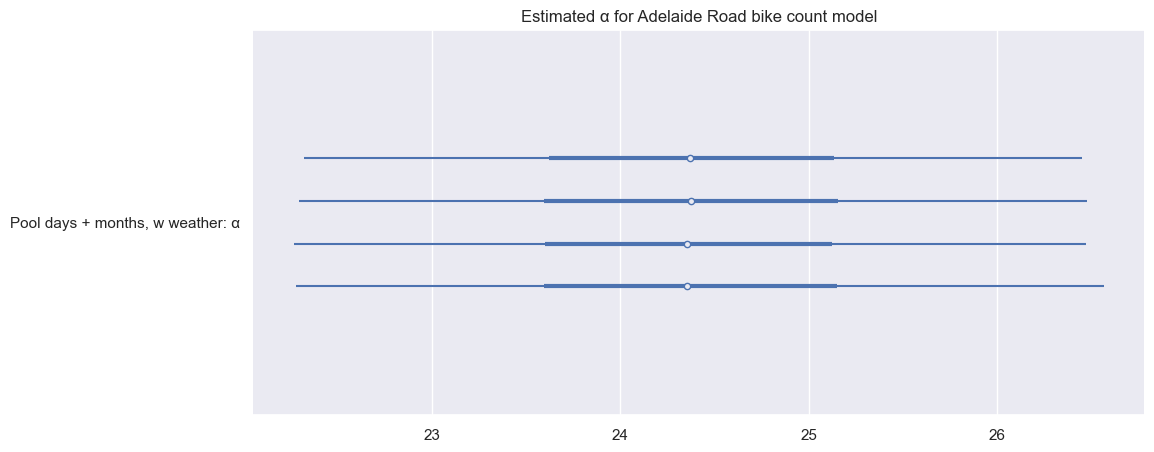

In [20]:
for param in "γβα":
    ax = az.plot_forest(
        list(traces.values()),
        model_names=list(traces.keys()),
        var_names=param,
        figsize=(11.5, 5),
    )
    ax[0].set_title(f"Estimated {param} for {SITE_NAMES[0]} bike count model")

    plt.show()